In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from collections import Counter
import seaborn as sns

%matplotlib inline
np.random.seed(12)

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, History, TensorBoard
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [ ]:
#Fetching Files
train_dir="train_images/"
validation_dir="valid_images/"
test_dir="test_images/"

train_image=[train_dir+i for i in os.listdir(train_dir)]
train_image=train_image[:100000]
test_image=[test_dir+i for i in os.listdir(test_dir)]
valid_image=[validation_dir+i for i in os.listdir(validation_dir)]

def fetch_data(dire):
    count=len(dire)
    data=np.ndarray((count, 80, 80, 3), dtype=np.uint8)
    for i, img in tqdm(enumerate(dire)):
        data[i]=cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (80,80))
    return data

train_data=fetch_data(train_image)
np.save('training1.npy', train_data)
valid_data=fetch_data(valid_image)
np.save('validating.npy', valid_data)
test_data=fetch_data(test_image)
np.save('testing.npy', test_data)
print("Train data size: ", train_data.shape)
print("Test data size: ", test_data.shape)
print("Validation data size: ", valid_data.shape)

In [2]:
#Fetching Data in case it has been preloaded and saved in files
train_data=np.load('training2.npy')
valid_data=np.load('validating.npy')
test_data=np.load('testing.npy')
train_labels=np.load('training_labels2.npy')
valid_labels=np.load('validating_labels.npy')

In [ ]:
#Fetching all train and validation labels
files=['train.json','validation.json']
train_annotations={}
valid_annotations={}
for file in files:
    j = json.load(open(file))
    annotations = {}
    _annotations = j['annotations']
    if 'train' in file:
        for annotation in _annotations:
            train_annotations[annotation['imageId']] = [int(i) for i in annotation['labelId']]
    else:
        for annotation in _annotations:
            valid_annotations[annotation['imageId']] = [int(i) for i in annotation['labelId']]   

In [ ]:
#Assigning labels to to all the training data
train_labels=[]
for x in train_image:
    y=x.split('/')[1].split('.')[0]
    train_labels.append(train_annotations[y])
valid_labels=[]
for x in valid_image:
    y=x.split('/')[1].split('.')[0]
    valid_labels.append(valid_annotations[y])

In [ ]:
#Deleting Annotations to free up memory and saving the labels
del train_annotations
del valid_annotations
np.save('training_labels1.npy', train_labels)
np.save('validating_labels.npy', valid_labels)

In [3]:
#Normalising the data between 0 and 1, so that the CNN can converge faster
train_data=train_data/255
valid_data=valid_data/255
test_data=test_data/255

In [4]:
#One-hot encoding all the labels using sklearn
labels=[]
for x in train_labels:
    labels.append(x)
for x in valid_labels:
    labels.append(x)
mlb=MultiLabelBinarizer()
lab=mlb.fit_transform(labels)
tr_labels=lab[:100000]
val_labels=lab[100000:]
del lab

Some images in training and Validation Set


/home/harsh1405/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


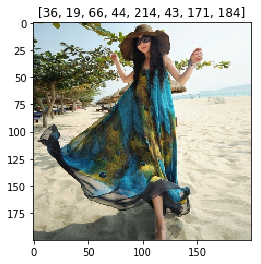

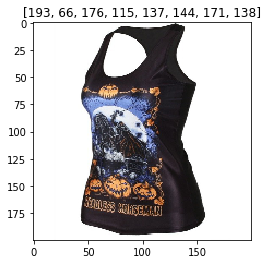

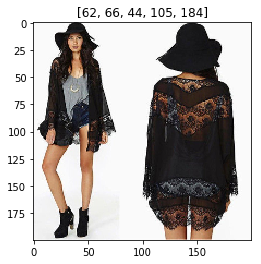

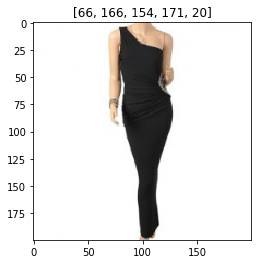

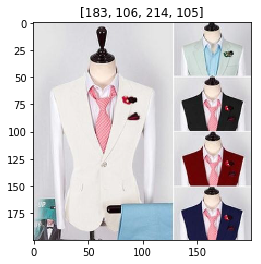

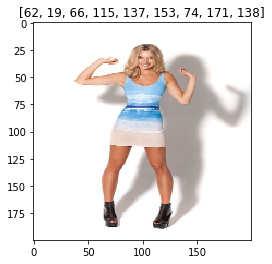

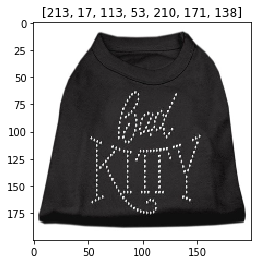

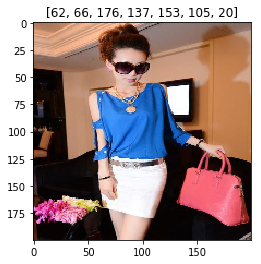

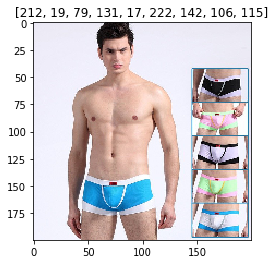

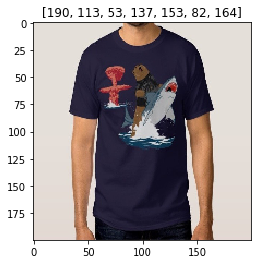

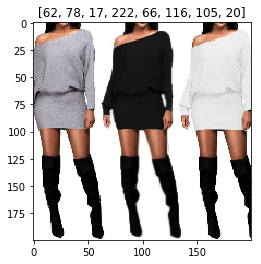

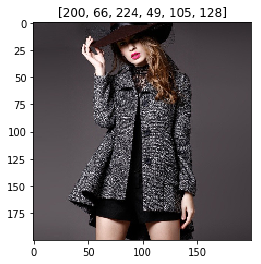

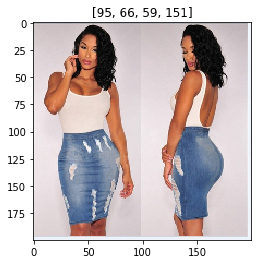

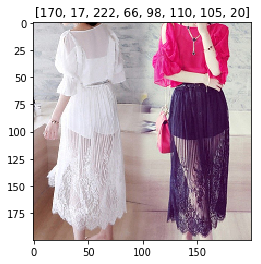

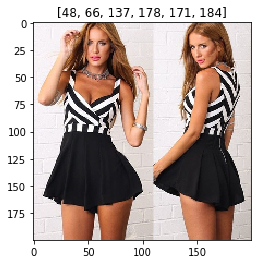

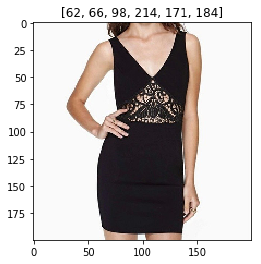

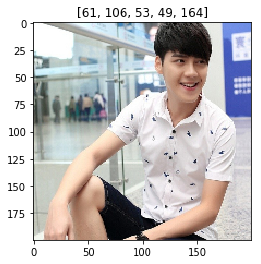

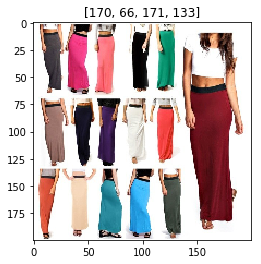

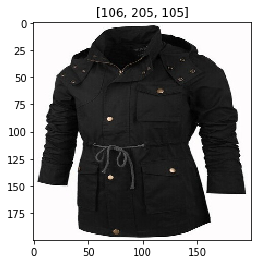

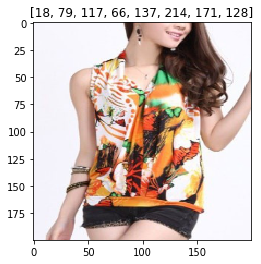

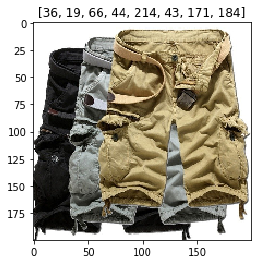

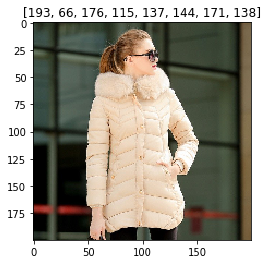

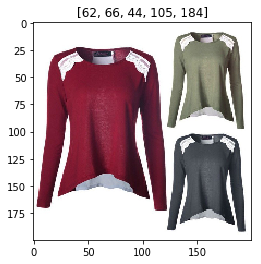

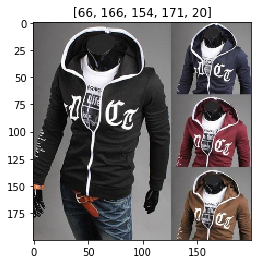

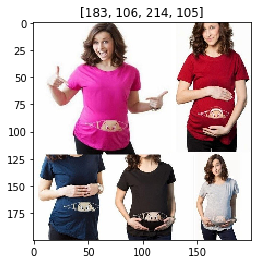

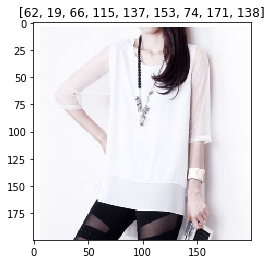

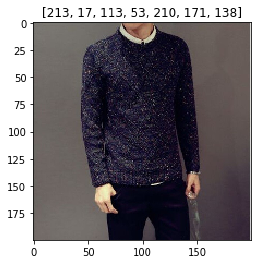

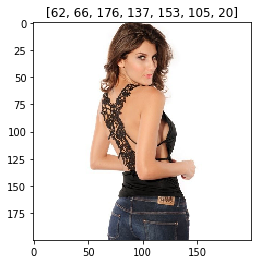

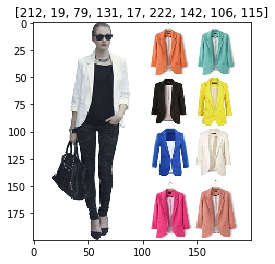

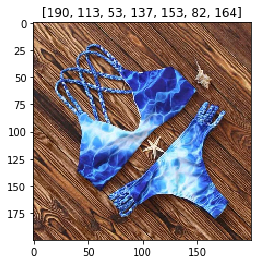

In [5]:
train_image=np.load("training_all.npy")
for x in range(len(train_image)):
    train_image[x]=cv2.cvtColor(train_image[x], cv2.COLOR_BGR2RGB)
train_image_labels=np.load("training_labels_all.npy")
valid_image=np.load("validating_all.npy")
for x in range(len(valid_image)):
    valid_image[x]=cv2.cvtColor(valid_image[x], cv2.COLOR_BGR2RGB)
valid_image_labels=np.load("validating_labels_all.npy")
print("Some images in training and Validation Set")
for x in range(20):
    plt.figure(figsize=(4,4))
    plt.imshow(train_image[x])
    plt.title(train_image_labels[x])
for x in range(10):
    plt.figure(figsize=(4,4))
    plt.imshow(valid_image[x])
    plt.title(valid_image_labels[x])
del train_image
del valid_image
del train_image_labels
del valid_image_labels

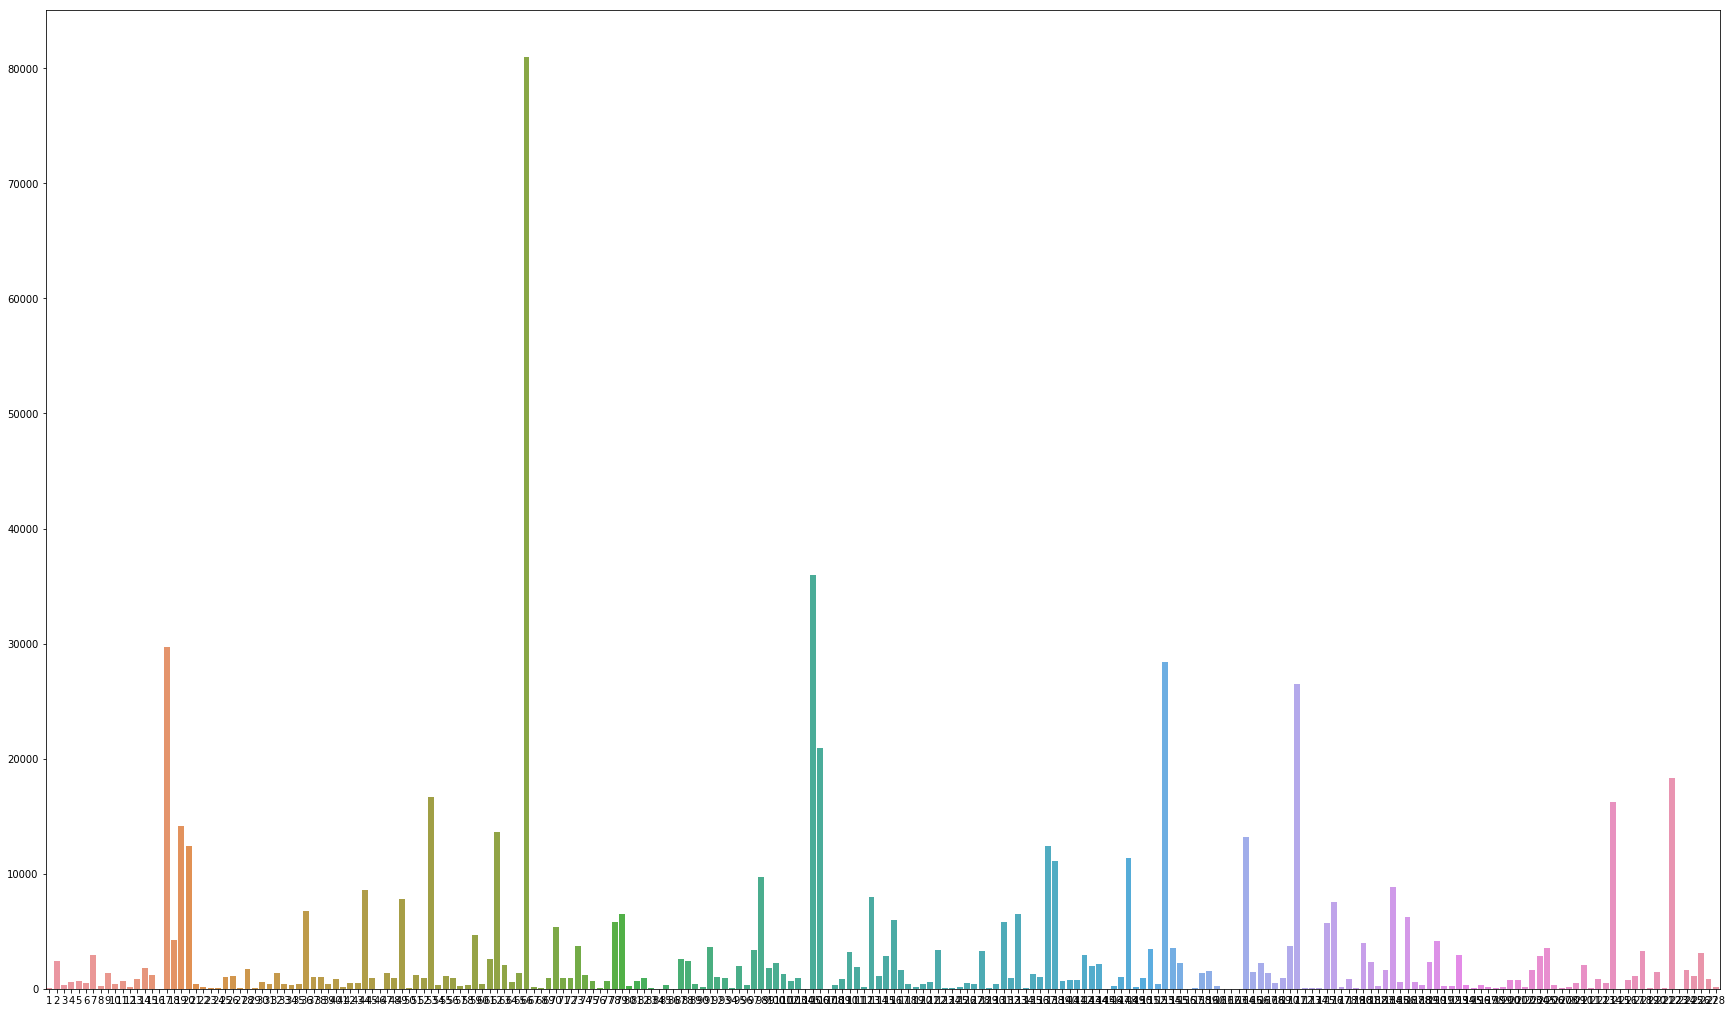

In [7]:
#Looking at the count of each label
lb=[item for sublist in labels for item in sublist]
lb=dict(Counter(lb))
lb_lists=lb.items()
x_lb, y_lb=zip(*lb_lists)
plt.figure(figsize=(30,18))
sns.barplot(x_lb, y_lb)

In [ ]:
#The ConvNet model used for training used to resemble VGG16
def imodel():
    model=Sequential()
    #First two convolution layers having 32 filters each
    model.add(Convolution2D(32, (3,3), padding='same',input_shape=(80,80,3), activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(32, (3,3), padding='same',activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #Next two convolution layers having 64 filters each
    model.add(Convolution2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #Next two convolution layers having 128 filters each
    model.add(Convolution2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #7th COnvolution layer having 256 filters
    model.add(Convolution2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #Adding the first fully connected layer having 1024 units
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #Next Dense layer haing 512 units
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #The last layer doing the classification having 228 units for each label
    model.add(Dense(228, activation='sigmoid'))
    
    return model

In [8]:
model=keras.models.load_model('iMaterialist_para.h5', {'tf': tf})#imodel() #In case the model has been trained first, keras.models.load_model('iMaterialist_para.h5', {'tf': tf})
#model.load_weights('iMaterialist_weights_para.h5')
parallel_model=multi_gpu_model(model, gpus=2)
optimizer=Adam(lr=0.0001)
history=History()
tboard=TensorBoard(log_dir='tbGraphs/', histogram_freq=1, batch_size=40, write_graph=True, write_grads=True, write_images=True)
checkpointer=ModelCheckpoint(filepath='/tmp/iMat_weights.hdf5', verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True)
parallel_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'fmeasure'])

In [9]:
#Training the model
history=parallel_model.fit(train_data, tr_labels, batch_size=64, validation_data=(valid_data,val_labels),\
                                    epochs=1, shuffle=True, verbose=1, callbacks=[history,checkpointer, tboard])

Train on 100000 samples, validate on 9897 samples
Epoch 1/1
100000/100000 [==============================] - 416s 4ms/step - loss: 0.0702 - acc: 0.9786 - fmeasure: 0.3734 - val_loss: 0.0985 - val_acc: 0.9713 - val_fmeasure: 0.3671

Epoch 00001: val_loss improved from inf to 0.09852, saving model to /tmp/iMat_weights.hdf5


In [10]:
#Saving the trained model
parallel_model.save('iMaterialist_para.h5')
parallel_model.save_weights('iMaterialist_weights_para.h5')

In [11]:
#Making predictions on test dataset and converting those predictions into original labels
predictions=parallel_model.predict(test_data)
predictions=(predictions>0.5).astype(int)
predictions=mlb.inverse_transform(predictions)
predictions=[np.asarray(x) for x in predictions]

In [27]:
image_ids=[]
image_ids.append([x.split('/')[1].split('.')[0] for x in test_image])
image_ids=[x for sublist in image_ids for x in sublist]

In [29]:
#Making a dictionary associating each imageid with its respective labels
predict_dictionary={}
predictions=('\n'.join(' '.join(str(cell) for cell in row) for row in predictions)).split('\n')
for x in range(len(image_ids)):
    predict_dictionary[image_ids[x]]=predictions[x]

In [30]:
#Converting the dictionary into a pandas dataframe and finally a csv file for submission
predict_df=pd.DataFrame(list(predict_dictionary.items()),columns=['image_id', 'label_id'])
predict_df[['image_id']]=predict_df[['image_id']].apply(pd.to_numeric)
predict_df=predict_df.sort_values(by=['image_id'])
predict_df.to_csv("Submission_File.csv", index=False)